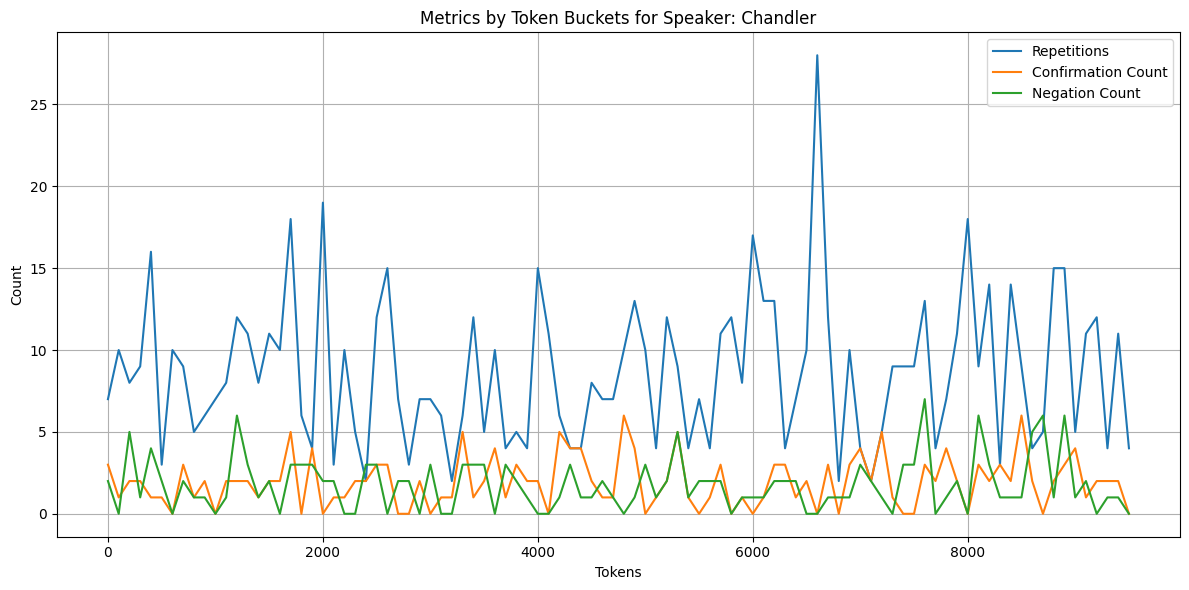

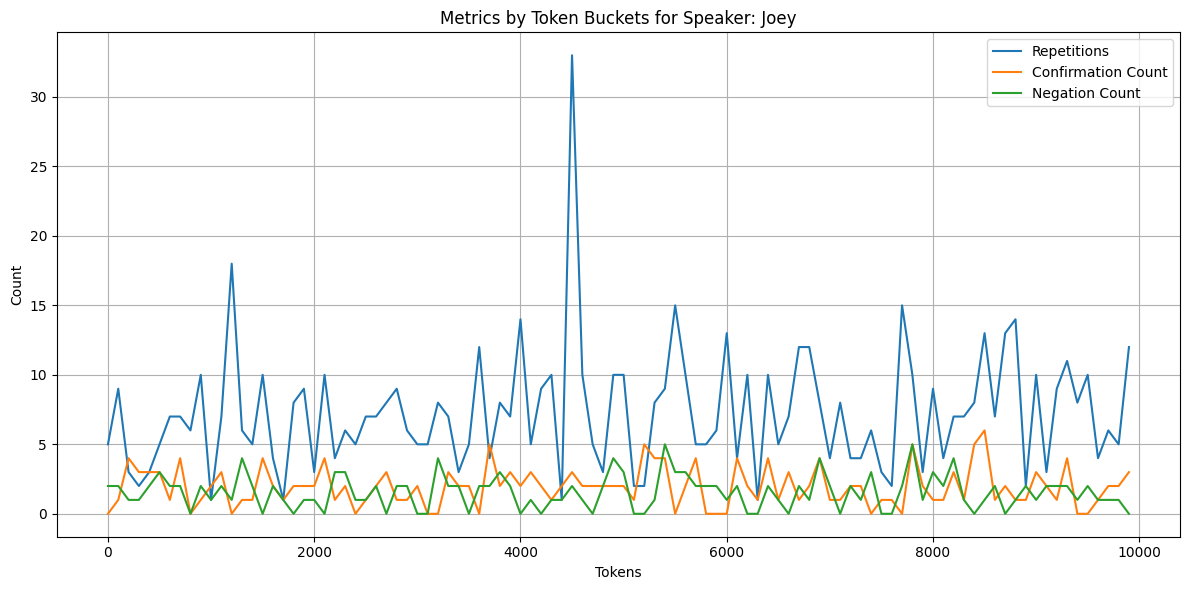

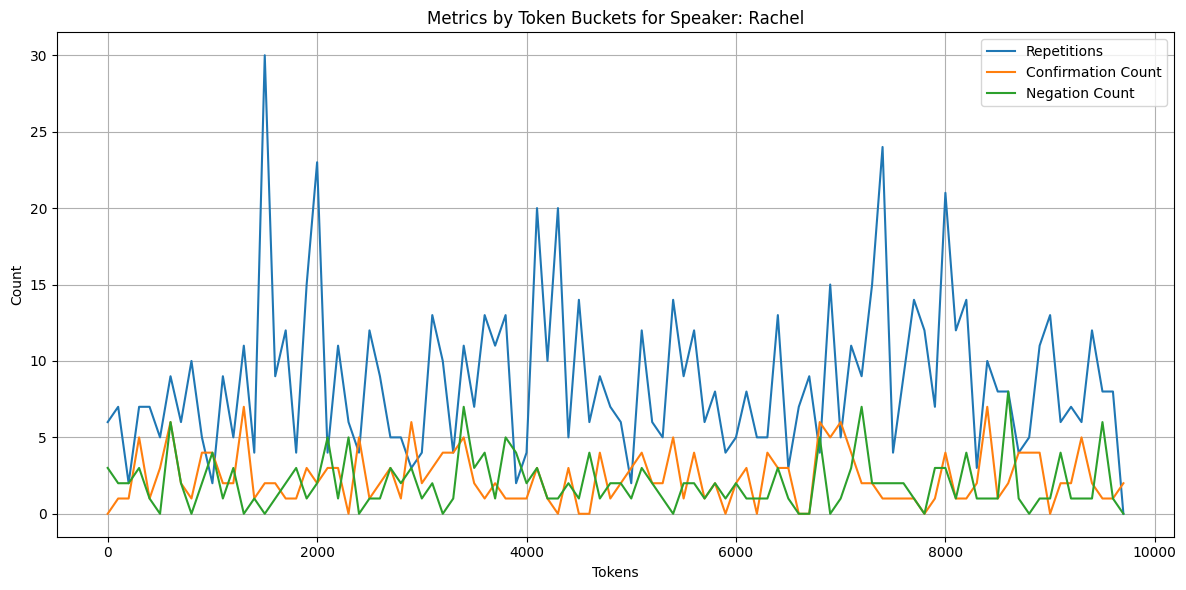

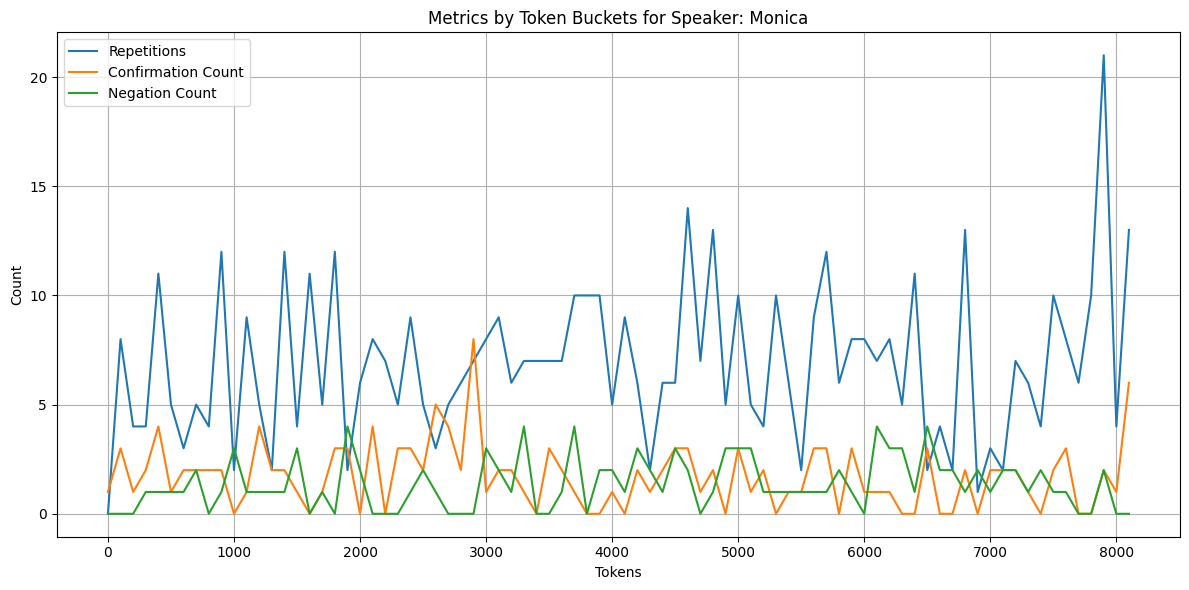

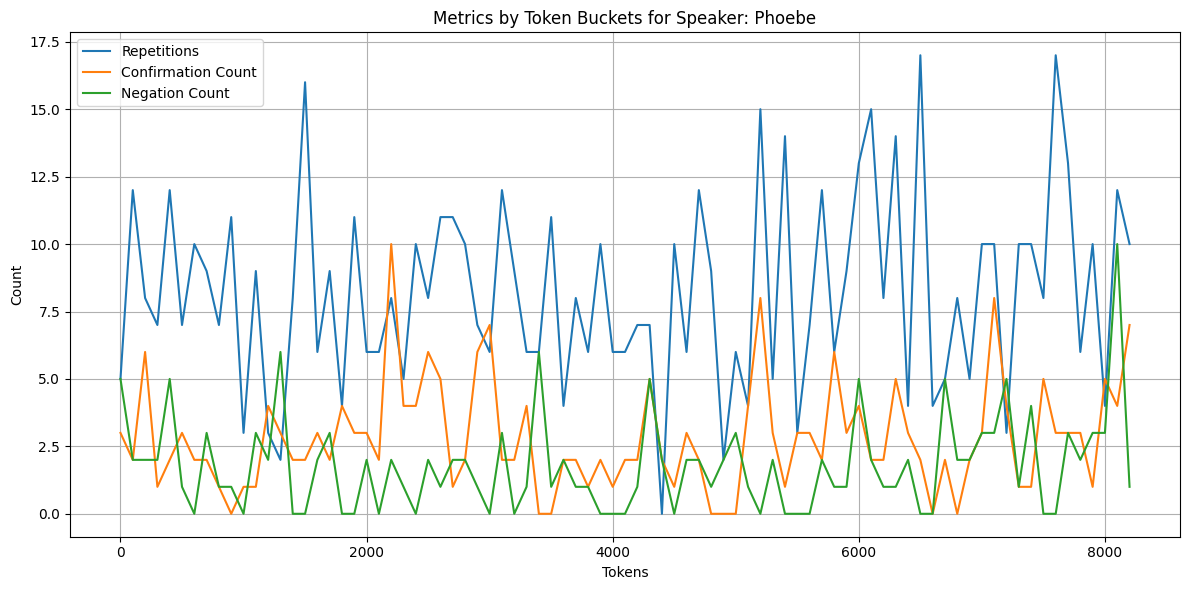

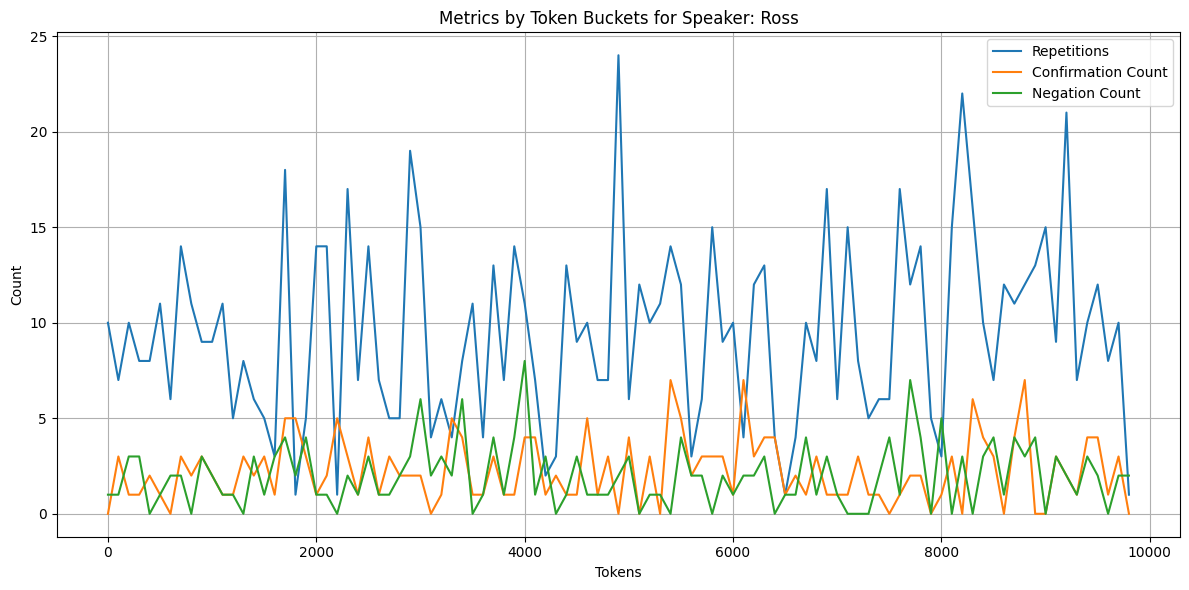

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np

# Define your words sets
confirmation_words = {'yes', 'yeah', 'yep', 'okay', 'alright', 'sure', 'absolutely', 'certainly', 'of course', 'indeed', 'definitely'}
negation_words = {'no', 'not', 'never', 'none', 'nor', 'nobody', 'neither', "don't", "isn't", "wasn't", "weren't", "doesn't", "won't", "haven't"}
stop_words = {}

def preprocess(tokens):
    return [
        token.translate(str.maketrans('', '', string.punctuation)).lower()
        for token in tokens if token not in stop_words
    ]

def calculate_row_metrics(speaker_df):
    # Metrics per row
    all_tokens = []
    token_sizes = []
    repetitions = []
    confirmation_counts = []
    negation_counts = []

    for _, row in speaker_df.iterrows():
        tokens = row['Utterance_1'].split()
        tokens = preprocess(tokens)
        all_tokens.append(tokens)

        # Token size
        token_size = len(tokens)
        token_sizes.append(token_size)

        # Word counts
        word_counts = Counter(tokens)
        
        # Calculations
        repetition_count = sum(count - 1 for word, count in word_counts.items() if count > 1)
        repetitions.append(repetition_count)

        confirmation_count = sum(count for word, count in word_counts.items() if word in confirmation_words)
        confirmation_counts.append(confirmation_count)

        negation_count = sum(count for word, count in word_counts.items() if word in negation_words)
        negation_counts.append(negation_count)

    speaker_df['Tokens'] = all_tokens
    speaker_df['Token Size'] = token_sizes
    speaker_df['Repetitions'] = repetitions
    speaker_df['Confirmation Count'] = confirmation_counts
    speaker_df['Negation Count'] = negation_counts

    return speaker_df

def calculate_bucket_metrics(speaker_df, bucket_size=100):
    # Cumulative token counter
    cumulative_tokens = 0
    bucket_metrics = {
        'Bucket': [],
        'Repetitions': [],
        'Confirmation Count': [],
        'Negation Count': []
    }
    
    current_bucket = 0
    bucket_repetitions = 0
    bucket_confirmations = 0
    bucket_negations = 0

    for _, row in speaker_df.iterrows():
        # Get counts for this utterance
        token_size = row['Token Size']
        cumulative_tokens += token_size

        # If we're in the same bucket, keep adding
        while cumulative_tokens > (current_bucket + 1) * bucket_size:
            # Save current bucket metrics
            bucket_metrics['Bucket'].append(current_bucket * bucket_size)
            bucket_metrics['Repetitions'].append(bucket_repetitions)
            bucket_metrics['Confirmation Count'].append(bucket_confirmations)
            bucket_metrics['Negation Count'].append(bucket_negations)
            
            # Reset metrics for the next bucket
            current_bucket += 1
            bucket_repetitions = 0
            bucket_confirmations = 0
            bucket_negations = 0

        # Add current row metrics to current bucket
        bucket_repetitions += row['Repetitions']
        bucket_confirmations += row['Confirmation Count']
        bucket_negations += row['Negation Count']

    # Add last bucket if not empty
    if bucket_repetitions > 0 or bucket_confirmations > 0 or bucket_negations > 0:
        bucket_metrics['Bucket'].append(current_bucket * bucket_size)
        bucket_metrics['Repetitions'].append(bucket_repetitions)
        bucket_metrics['Confirmation Count'].append(bucket_confirmations)
        bucket_metrics['Negation Count'].append(bucket_negations)
    
    return pd.DataFrame(bucket_metrics)

def calculate_metrics(speaker_df):

    tokens = [token for sublist in speaker_df['Tokens'].values for token in sublist]
    total_tokens = len(tokens)
    
    vocabulary_set = set(tokens)
    vocabulary_size = len(vocabulary_set)

    total_repetitions = sum(speaker_df['Repetitions'].values)
    total_confirmations = sum(speaker_df['Confirmation Count'].values)
    total_negations = sum(speaker_df['Negation Count'].values)
    
    metrics = {}
    metrics['Vocabulary Size'] = vocabulary_size
    metrics['Total Tokens'] = total_tokens
    metrics['Total Repetitions'] = total_repetitions
    metrics['Total Confirmations'] = total_confirmations
    metrics['Total Negations'] = total_negations
    
    return metrics

def calculate_average_personality(speaker_df):
    personality_columns = ['Personality']
    averages = {trait: eval(speaker_df[trait].iloc[0]) for trait in personality_columns}
    return averages

# Load your data
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)

# Create a dictionary of DataFrames with each subset being a copy of the relevant data
speakers = df['Speaker_1'].unique()
speaker_dfs = {speaker: df[df['Speaker_1'] == speaker].copy() for speaker in speakers}

all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in speaker_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [ ]:
df_metrics

In [ ]:
df_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Speaker Metrics')
plt.ylabel('Count')
plt.xlabel('Speaker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import ast

# Define a function to extract the dominant personality
def get_dominant_personality(row):
    # Convert the string representation of the list to an actual list of floats
    trait_probabilities = ast.literal_eval(row['Personality'])
    max_trait_index = np.argmax(trait_probabilities)
    
    return max_trait_index

# Apply this function to each row in df_raw and assign result to 'Dominant Personality' column
df['Dominant Personality'] = df.apply(get_dominant_personality, axis=1)

# Print the value counts of the 'Dominant Personality' column
print(df['Dominant Personality'].value_counts())

# Convert the values in the 'Dominant Personality' column to int and store them in a list
dominant_personalities = df['Dominant Personality'].tolist()
dominant_personalities = [int(x) for x in dominant_personalities]

print(dominant_personalities)


In [ ]:
import pandas as pd

personality_dfs = {}
for personality in df['Dominant Personality'].unique():
    personality_dfs[personality] = df[df['Dominant Personality'] == personality]


# Example: Print the first few rows of each dataframe
for personality, dataframe in personality_dfs.items():
    print(f"Dominant Personality {personality}:")
    print(dataframe.head())


In [ ]:
all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in personality_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [ ]:
df_metrics

In [ ]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity

# Combine all text in the 'Utterance_1' column for each speaker into a single string
combined_texts = {speaker: " ".join(speaker_df['Utterance_1'].tolist()) for speaker, speaker_df in speaker_dfs.items()}

# Prepare data for doc2vec
documents = [TaggedDocument(words=text.split(), tags=[speaker]) for speaker, text in combined_texts.items()]

# Train doc2vec model
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Function to generate embeddings using doc2vec
def generate_embedding(text):
    return model.infer_vector(text.split())

# Personality trait definitions with both sides of the spectrum
personality_definitions = {
    'Extraversion': [('Talkative', 'Silent'), ('Sociable', 'Reclusive'), ('Adventurous', 'Cautious'), ('Open', 'Secretive')],
    'Agreeableness': [('Good-natured', 'Irritable'), ('Cooperative', 'Negativistic'), ('Mild/gentle', 'Headstrong'), ('Not jealous', 'Jealous')],
    'Conscientiousness': [('Responsible', 'Undependable'), ('Scrupulous', 'Unscrupulous'), ('Persevering', 'Quitting'), ('Fussy/tidy', 'Careless')],
    'Emotional Stability': [('Calm', 'Anxious'), ('Composed', 'Excitable'), ('Not hypochondriacal', 'Hypochondriacal'), ('Poised', 'Nervous/tense')],
    'Culture/Intellect, Openness': [('Intellectual', 'Unreflective/narrow'), ('Artistic', 'Non artistic'), ('Imaginative', 'Simple/direct'), ('Polished/refined', 'Crude/boorish')]
}

# Generate embeddings for both sides of each trait spectrum
personality_embeddings = {}
for trait, definitions in personality_definitions.items():
    personality_embeddings[trait] = [(generate_embedding(defn[0]), generate_embedding(defn[1])) for defn in definitions]

# Function to compute the position on the spectrum for a trait
def compute_trait_position(dataframe_embedding, trait_embeddings):
    positions = []
    for pos_emb, neg_emb in trait_embeddings:
        pos_score = cosine_similarity([dataframe_embedding], [pos_emb])[0][0]
        neg_score = cosine_similarity([dataframe_embedding], [neg_emb])[0][0]
        position = pos_score - neg_score  # Positive if closer to positive side, negative if closer to negative side
        positions.append(position)
    return np.mean(positions)  # Average position for the trait

# Process each speaker's combined text
for speaker, combined_text in combined_texts.items():
    # Generate embedding for the combined text
    combined_embedding = generate_embedding(combined_text)
    
    # Compute positions for each trait
    trait_positions = {}
    for trait, embeddings in personality_embeddings.items():
        trait_positions[trait + '_Position'] = compute_trait_position(combined_embedding, embeddings)
    
    # Print the results for the current speaker
    print(f"Results for {speaker}:")
    for trait, position in trait_positions.items():
        print(f"{trait}: {position}")


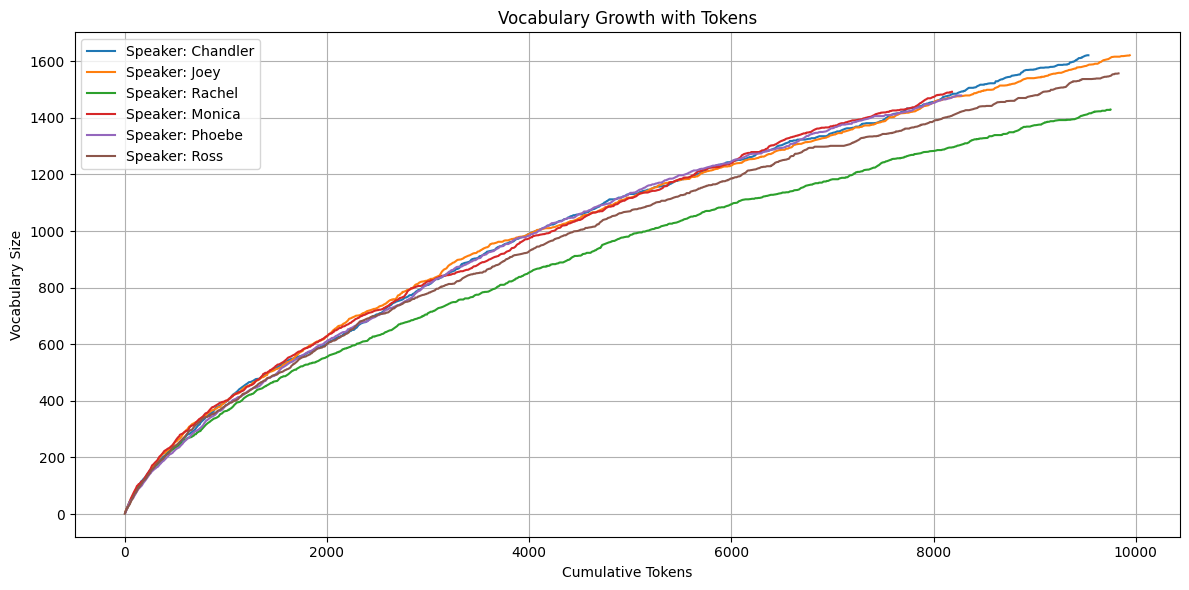

Speaker: Chandler
Perplexity: 39015.536584537906


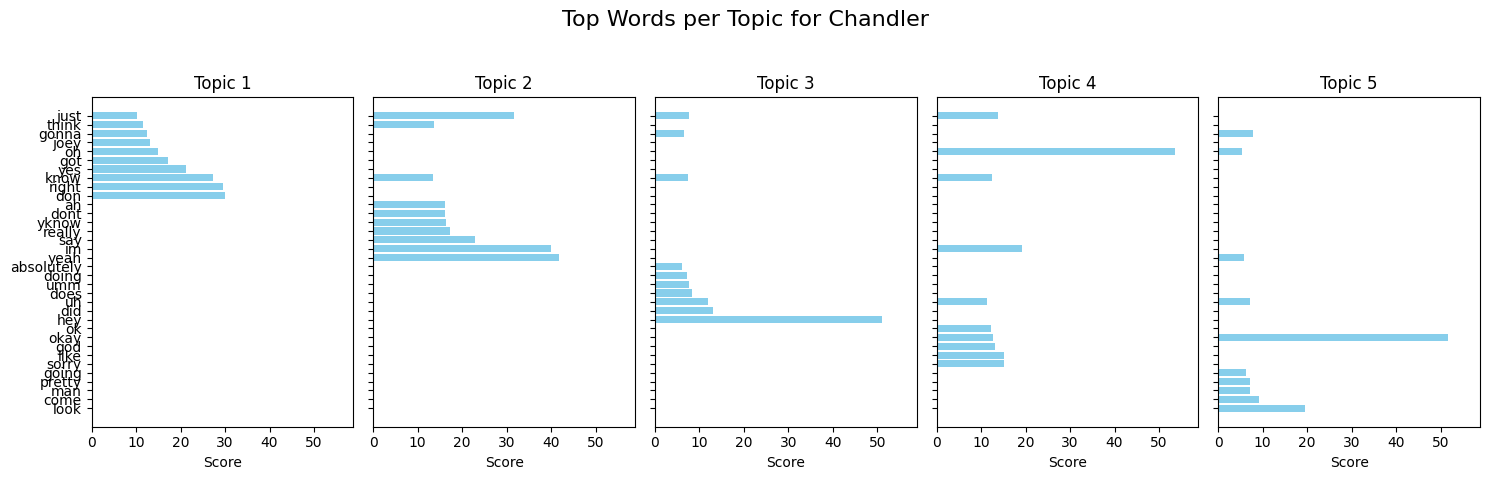

Speaker: Joey
Perplexity: 43730.26588488831


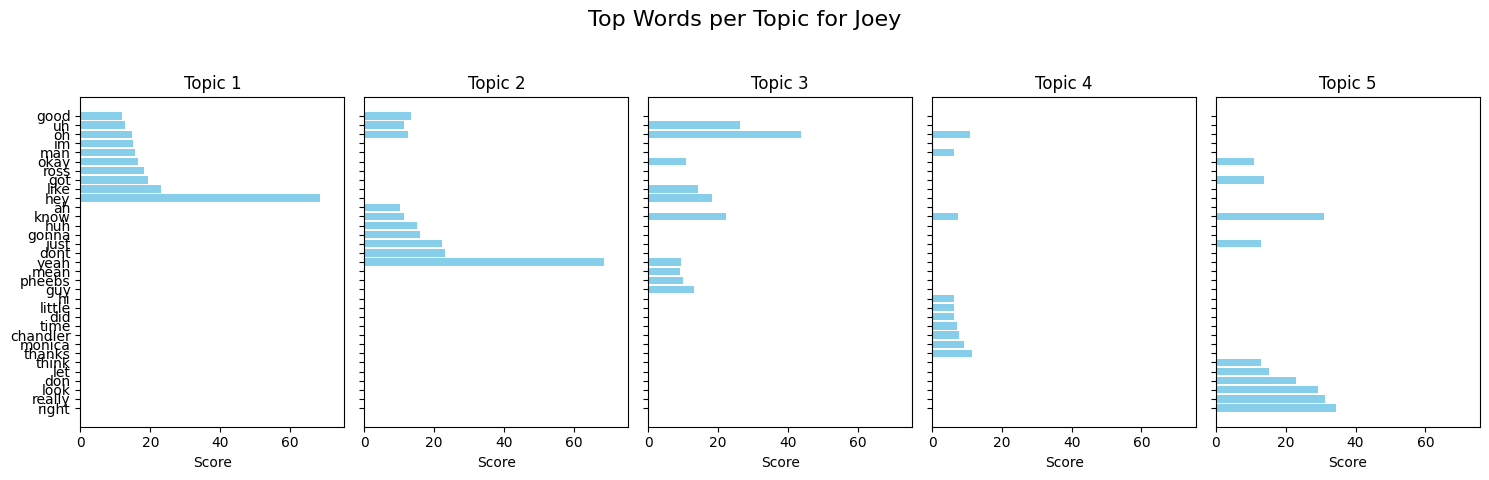

Speaker: Rachel
Perplexity: 24185.28548133433


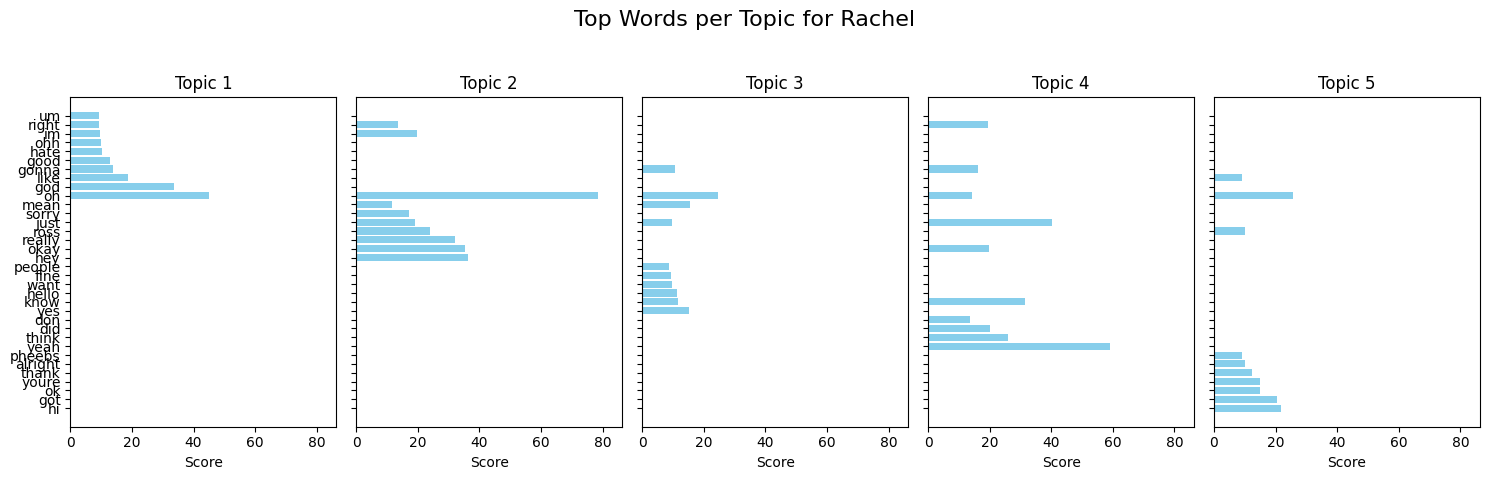

Speaker: Monica
Perplexity: 62036.45023935169


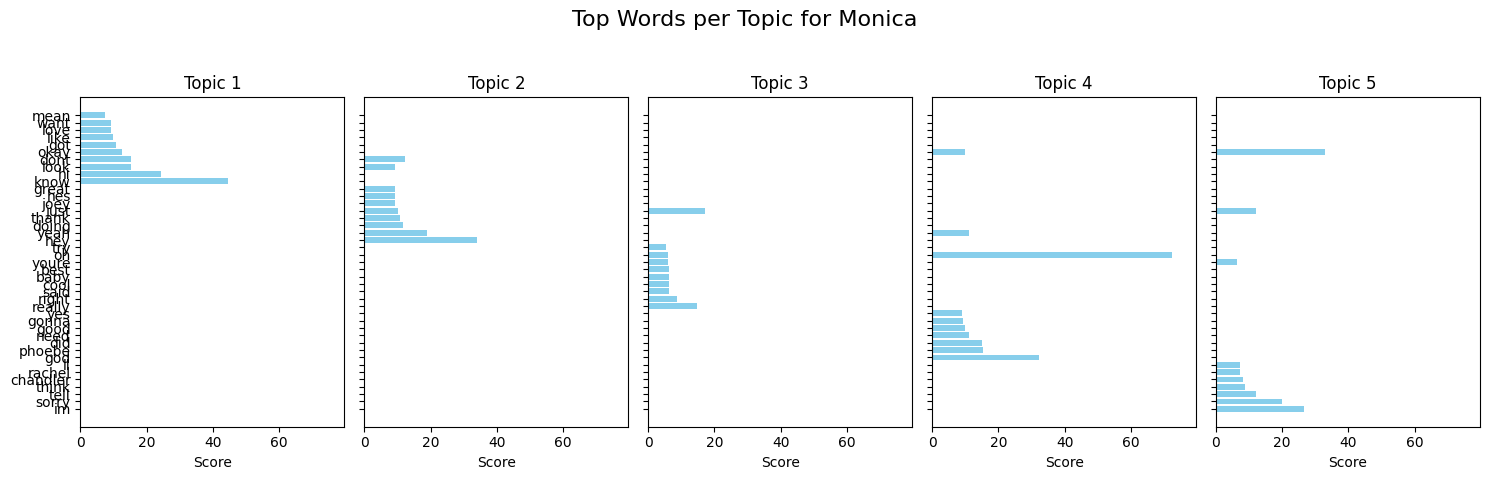

Speaker: Phoebe
Perplexity: 55371.330035048566


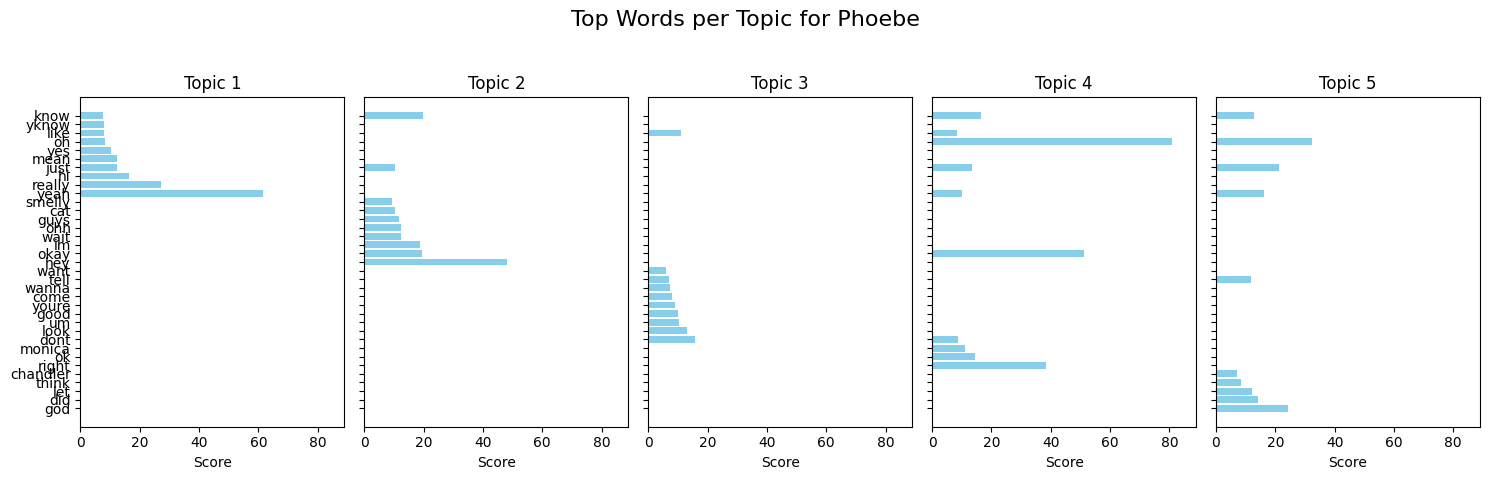

Speaker: Ross
Perplexity: 37513.50388991866


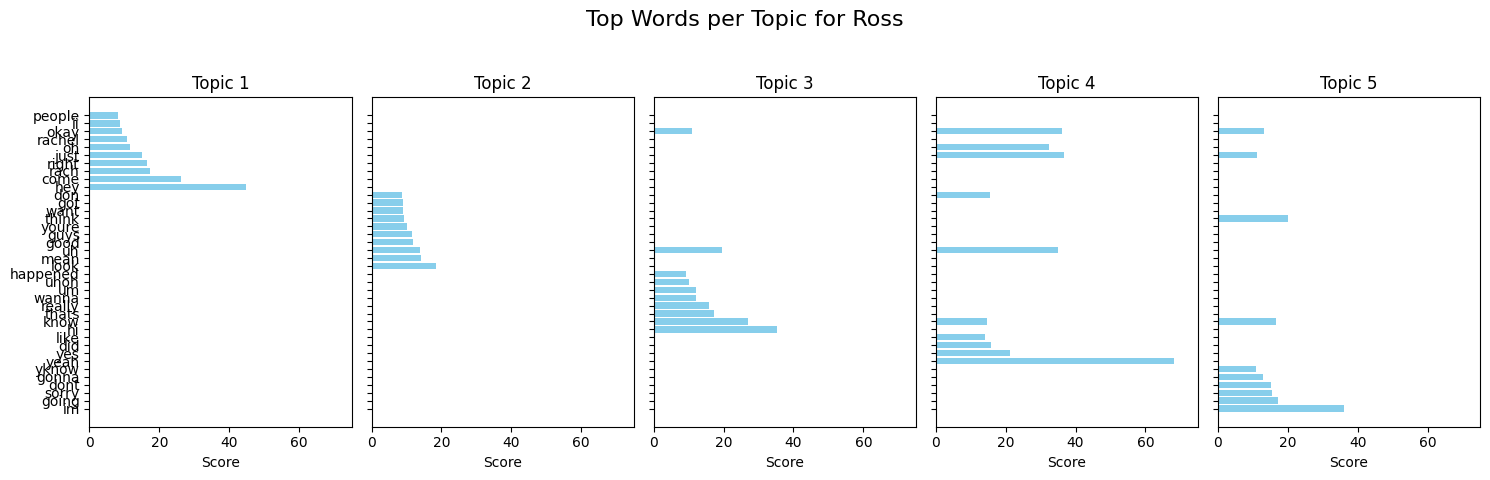

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split

# Part 1: Vocabulary Growth per Token

# Function to calculate cumulative vocabulary growth with respect to tokens
def calculate_vocabulary_growth(speaker_df):
    cumulative_tokens = 0
    cumulative_vocabulary = set()
    vocabulary_growth = {'Tokens': [], 'Vocabulary': []}

    for _, row in speaker_df.iterrows():
        tokens = row['Tokens']
        cumulative_tokens += len(tokens)
        
        # Update vocabulary with new tokens
        cumulative_vocabulary.update(tokens)
        vocabulary_size = len(cumulative_vocabulary)

        # Append cumulative data
        vocabulary_growth['Tokens'].append(cumulative_tokens)
        vocabulary_growth['Vocabulary'].append(vocabulary_size)

    return pd.DataFrame(vocabulary_growth)

# Plot vocabulary growth for each speaker
plt.figure(figsize=(12, 6))
for speaker, speaker_df in speaker_dfs.items():
    vocab_growth_df = calculate_vocabulary_growth(speaker_df)
    plt.plot(vocab_growth_df['Tokens'], vocab_growth_df['Vocabulary'], label=f'Speaker: {speaker}')
    
plt.title(f'Vocabulary Growth with Tokens')
plt.xlabel('Cumulative Tokens')
plt.ylabel('Vocabulary Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Part 2: LDA Topic Modeling and Plotting

# Function to perform LDA topic modeling and return topics
def lda_topic_modeling(tokens_list, num_topics=5):
    # Join tokens into a single string for each document
    preprocessed_text = [' '.join(tokens) for tokens in tokens_list]
    
    # Create CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')
    count_data = vectorizer.fit_transform(preprocessed_text)

    # Split the data into train and test sets
    X_train, X_test = train_test_split(count_data, test_size=0.2, random_state=42)
    
    # Create an LDA model
    lda = LDA(n_components=num_topics, random_state=42)
    lda.fit(X_train)

    # Evaluate model using perplexity
    perplexity = lda.perplexity(X_test)
    
    # Get feature names for interpreting topics
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(lda.components_):
        topics[f"Topic {idx+1}"] = [(feature_names[i], topic[i]) for i in topic.argsort()[-10:]]

    return perplexity, topics


def plot_lda_topics(topics, speaker):
    num_topics = len(topics)
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 5), sharey=True)
    fig.suptitle(f"Top Words per Topic for {speaker}", fontsize=16)

    # Collect max score for consistent x-axis limits
    max_score = max(max([score for _, score in words]) for words in topics.values())

    for idx, (topic, words) in enumerate(topics.items()):
        words, scores = zip(*words)
        axes[idx].barh(words, scores, color='skyblue')
        axes[idx].set_title(topic)
        axes[idx].invert_yaxis()  # Top words at the top of the plot
        axes[idx].set_xlim(0, max_score * 1.1)  # Set x-axis limits for consistency
        axes[idx].set_xlabel('Score')
        axes[idx].tick_params(axis='y', labelsize=10)  # Adjust y-axis font size

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# Applying LDA and plotting for each speaker
for speaker, speaker_df in speaker_dfs.items():
    tokens_list = speaker_df['Tokens'].tolist()  # Get list of tokens for the speaker
    perplexity, topics = lda_topic_modeling(tokens_list)
    
    print(f"Speaker: {speaker}")
    print("Perplexity:", perplexity)
    plot_lda_topics(topics, speaker)



In [37]:
nrc_lexicon = pd.read_csv("NRC_EmoLex_NRC-VAD-Lexicon.txt", sep='\t', header=None, names=['Word', 'Valence', 'Arousal', 'Dominance'])

results = {}

def calculate_vad_statistics(speaker_df):
    all_tokens = [token for tokens in speaker_df['Tokens'] for token in tokens]
    
    # Filter the NRC lexicon to get only the terms present in the speaker's tokens
    speaker_terms = nrc_lexicon[nrc_lexicon['Word'].isin(all_tokens)]
    
    if not speaker_terms.empty:
        results[speaker_df['Speaker'].iloc[0]] = {
            'Valence_Avg': speaker_terms['Valence'].mean(),
            'Arousal_Avg': speaker_terms['Arousal'].mean(),
            'Dominance_Avg': speaker_terms['Dominance'].mean(),
            'Valence_Std': speaker_terms['Valence'].std(),
            'Arousal_Std': speaker_terms['Arousal'].std(),
            'Dominance_Std': speaker_terms['Dominance'].std(),
            'Valence_Min': speaker_terms['Valence'].min(),
            'Arousal_Min': speaker_terms['Arousal'].min(),
            'Dominance_Min': speaker_terms['Dominance'].min(),
            'Valence_Max': speaker_terms['Valence'].max(),
            'Arousal_Max': speaker_terms['Arousal'].max(),
            'Dominance_Max': speaker_terms['Dominance'].max(),
            'Num_Lexicon_Terms': speaker_terms.shape[0]
        }


for speaker, speaker_df in speaker_dfs.items():
    speaker_df['Speaker'] = speaker  # Add a speaker column for reference
    calculate_vad_statistics(speaker_df)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df

,Valence_Avg,Arousal_Avg,Dominance_Avg,Valence_Std,Arousal_Std,Dominance_Std,Valence_Min,Arousal_Min,Dominance_Min,Valence_Max,Arousal_Max,Dominance_Max,Num_Lexicon_Terms
Chandler,0.570552,0.460898,0.491756,0.230104,0.178745,0.174659,0.010,0.071,0.081,1.0,0.945,0.943,896.0
Joey,0.597765,0.455071,0.498987,0.214599,0.175974,0.172411,0.020,0.073,0.120,1.0,0.945,0.972,863.0
Rachel,0.588662,0.462931,0.491867,0.232786,0.186783,0.175200,0.020,0.082,0.113,1.0,0.952,0.981,773.0
Monica,0.586088,0.459250,0.482580,0.224799,0.187390,0.172099,0.010,0.046,0.081,1.0,0.951,0.981,821.0
Phoebe,0.578601,0.463010,0.491933,0.228719,0.184041,0.168369,0.010,0.090,0.087,1.0,0.971,0.963,786.0
Ross,0.594269,0.466469,0.498248,0.227315,0.186104,0.175508,0.005,0.073,0.081,1.0,0.959,0.963,834.0


In [36]:
# Insights on personality traits based on VAD scores
for speaker in results_df.index:
    valence = results_df.loc[speaker, 'Valence_Avg']
    arousal = results_df.loc[speaker, 'Arousal_Avg']
    dominance = results_df.loc[speaker, 'Dominance_Avg']
    
    # Example of commenting
    if valence < 0.5 and arousal < 0.45:
        print(f"{speaker} tends to exhibit negative emotions and low energy, possibly indicating traits like introversion.")
    elif valence > 0.5 and arousal > 0.45:
        print(f"{speaker} tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.")


Chandler tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.
Joey tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.
Rachel tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.
Monica tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.
Phoebe tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.
Ross tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.
